<a href="https://colab.research.google.com/github/JR-1991/Catalax/blob/master/examples/GenerateData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install catalax
!pip install catalax

In [1]:
import catalax as ctx
import numpy as np
import jax.numpy as jnp
import json

/Users/jara1991/anaconda3/envs/catalax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

model

Model summary


Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[v_max, K_m]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None


In [3]:

# Data is sampled at different time points
# and also not at zero to reflect realistic
# scenarios
n_ds = 30

time = jnp.array([
    *[[10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 120],]*n_ds
])

# Set initial conditions above and below the 
# true Km value for the sake of the example
initial_conditions = []

for _ in range(n_ds):
    initial_conditions += [
        {"s1": np.random.normal(300.0, 8.0)},
        {"s1": np.random.normal(200.0, 8.0)},
        {"s1": np.random.normal(80.0, 8.0)},
        {"s1": np.random.normal(50.0, 8.0)},
    ]

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1, saveat=time, in_axes=(0, None, 0)
)

# Add some noise for realism
data = np.random.normal(data, 1.0).clip(min=0)

# Turn intiial conditions into a matrix (Not yet part of the NeuralODE workflow)
y0s = model._assemble_y0_array(initial_conditions, in_axes=(0, None, None))

# Save the data
jnp.save("data/time.npy", time)
jnp.save("data/data.npy", data)
jnp.save("data/y0s.npy", y0s)

with open("./data/initial_conditions.json", "w") as f:
    json.dump(initial_conditions, f, indent=2)

print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")

Time: (120, 6) | Data: (120, 6, 1) | Initial Conditions: (120, 1)


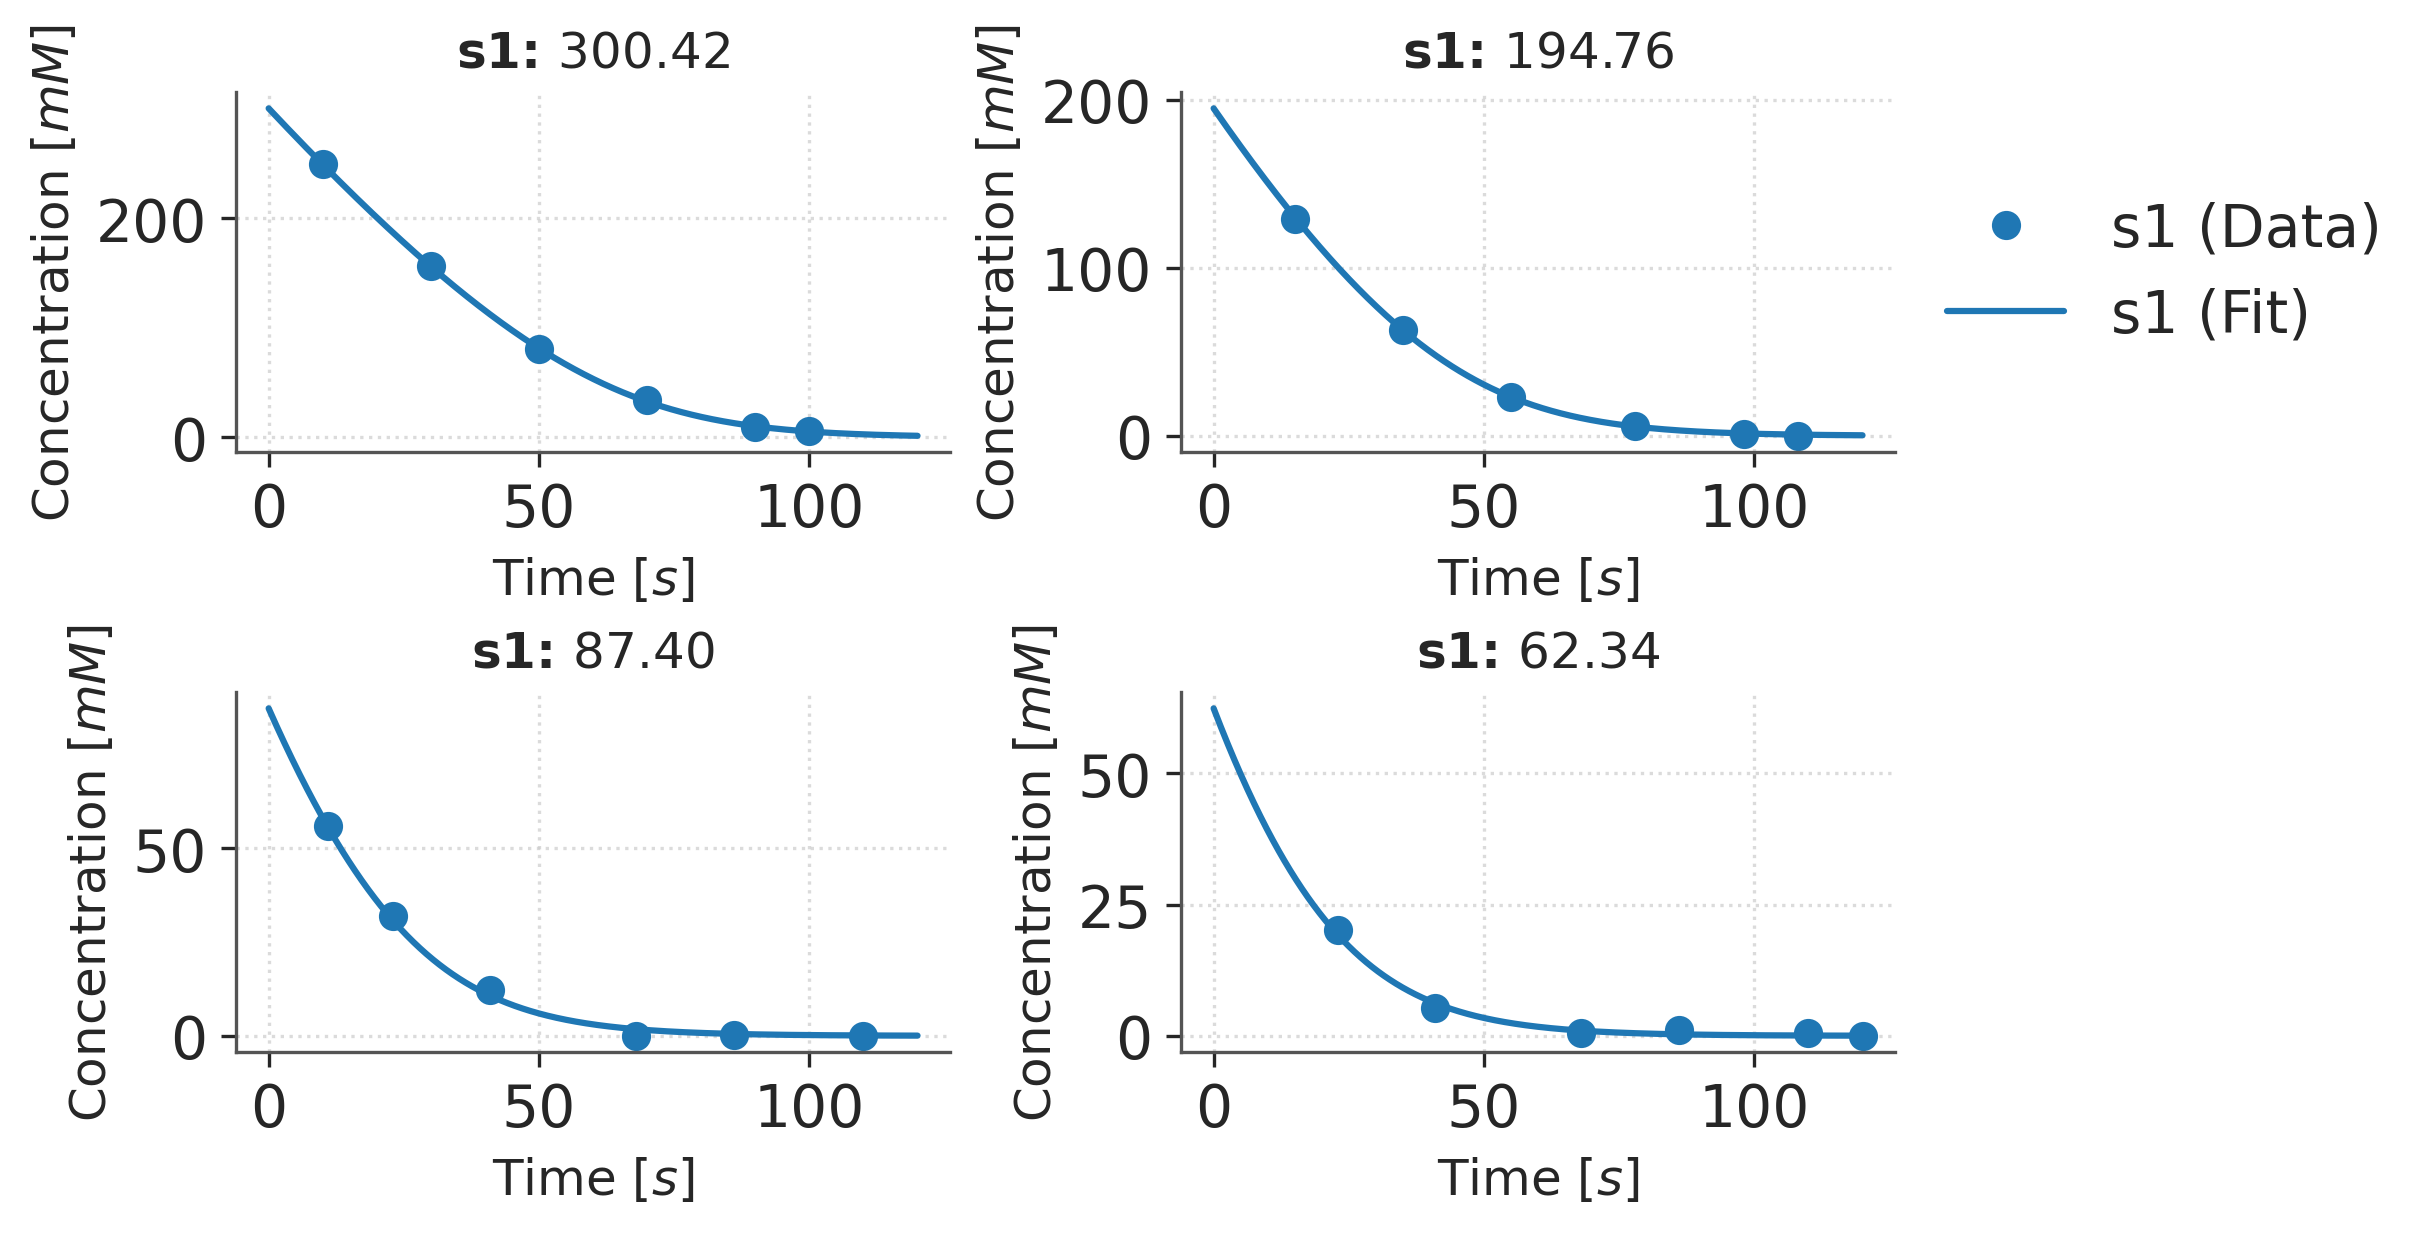

In [4]:
# Visualize the data
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
)